In [1]:
import pandas as pd
import numpy as np
from env import user, password, host
import acquire        
from acquire import url, query
import prepare
import explore
from scipy import stats
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
df = pd.read_sql(query, url)
df

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,fips,transactiondate
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23
...,...,...,...,...,...,...,...,...,...,...,...
28119,11991766,6.0,2.0,2634.0,878190.0,12766.88,2016.0,3101.0,95985.0,6037.0,2017-08-31
28120,14011468,4.0,1.5,1187.0,465999.0,5552.68,2016.0,1286.0,96180.0,6059.0,2017-08-31
28121,14453399,5.0,3.0,3015.0,852813.0,11662.88,2016.0,1286.0,96983.0,6059.0,2017-08-31
28122,11128688,5.0,3.0,2992.0,1120000.0,13663.03,2016.0,3101.0,96356.0,6037.0,2017-08-31


### Takeways
- My SQL query brings in all the columns necessary to ask the questions posed by the zillow team narrowing down the database to single unit properties with transactions during May-Aug 2017
- I am bringing in 28,124 rows and 11 columns initially

# Prepare

I need to prepare one dataframe for answering the questions posed I named df that will include the tax rate, and a 2nd dataframe name df2 that is for exploring and modeling which will not include the tax rate as this would cause target leakage.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28124 non-null  int64  
 1   bedroomcnt                    28124 non-null  float64
 2   bathroomcnt                   28124 non-null  float64
 3   calculatedfinishedsquarefeet  28077 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   assessmentyear                28124 non-null  float64
 7   regionidcounty                28124 non-null  float64
 8   regionidzip                   28107 non-null  float64
 9   fips                          28124 non-null  float64
 10  transactiondate               28124 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,28124.0,1.304239e+07,3.747700e+06,10711855.00,11513802.75,12596700.00,1.414914e+07,1.676878e+08
bedroomcnt,28124.0,3.309487e+00,9.430731e-01,0.00,3.00,3.00,4.000000e+00,1.200000e+01
bathroomcnt,28124.0,2.316509e+00,1.016983e+00,0.00,2.00,2.00,3.000000e+00,1.100000e+01
calculatedfinishedsquarefeet,28077.0,1.934930e+03,9.956845e+02,240.00,1278.00,1675.00,2.326000e+03,1.724500e+04
taxvaluedollarcnt,28123.0,5.350049e+05,7.076811e+05,1000.00,198636.00,382798.00,6.327670e+05,2.385837e+07
taxamount,28123.0,6.508829e+03,8.221720e+03,51.26,2705.33,4735.28,7.528405e+03,2.767978e+05
assessmentyear,28124.0,2.016000e+03,0.000000e+00,2016.00,2016.00,2016.00,2.016000e+03,2.016000e+03
regionidcounty,28124.0,2.509061e+03,8.085885e+02,1286.00,1286.00,3101.00,3.101000e+03,3.101000e+03
regionidzip,28107.0,9.665625e+04,5.130263e+03,95982.00,96208.00,96414.00,9.699500e+04,3.996750e+05
fips,28124.0,6.049521e+03,2.130214e+01,6037.00,6037.00,6037.00,6.059000e+03,6.111000e+03


In [5]:
df.shape

(28124, 11)

In [6]:
df.columns

Index(['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'taxamount', 'assessmentyear', 'regionidcounty',
       'regionidzip', 'fips', 'transactiondate'],
      dtype='object')

In [7]:
df.dtypes

parcelid                          int64
bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
taxamount                       float64
assessmentyear                  float64
regionidcounty                  float64
regionidzip                     float64
fips                            float64
transactiondate                  object
dtype: object

In [8]:
df =prepare.prep_zillow_data(df)

In [9]:
df.columns

Index(['parcelid', 'bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount',
       'assessment_year', 'county_id', 'regionidzip', 'zipcode',
       'transaction_date', 'tax_rate'],
      dtype='object')

<Figure size 576x720 with 0 Axes>

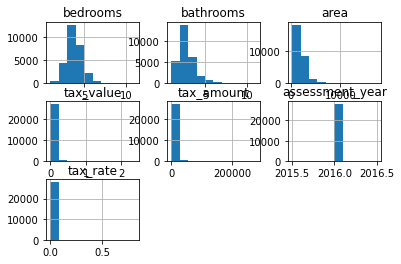

<Figure size 576x720 with 0 Axes>

In [10]:
df.hist()
plt.figure(figsize=(8,10))

In [11]:
df2 = df

### With the plot below I answer the request for the distribution of tax rates for each county:
- 3101 = Los Angeles,  1286 = Orange County,  2061 = Ventura
- As you can see below the average tax rate for Los Angeles is the highest, followed by Orange County and then the least is Ventura.

In [12]:
# here you can see how many homes reside in each county
df.county_id.value_counts()

3101.0    17839
1286.0     7723
2061.0     2419
Name: county_id, dtype: int64

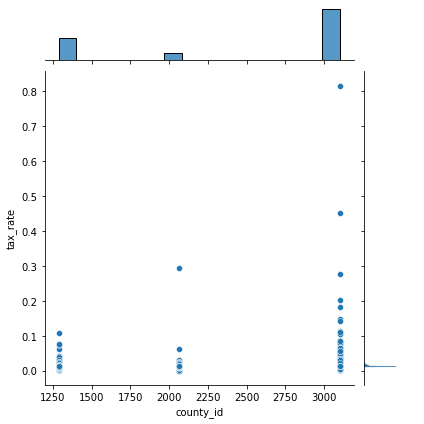

In [13]:
# here you can visualize the distribution
sns.jointplot(x=df["county_id"], y=df["tax_rate"], kind='scatter')

### Data dictionary

| Feature               | Datatype               | Description                                                |
|:----------------------|:-----------------------|:-----------------------------------------------------------|
| assessmentyear        | int64                  | The year of the property tax assessment                    | 
| bathrooms             | float64                | Number of bathrooms in home including fractional bathrooms |
| bedrooms              | float64                | Number of bedrooms in home                                 |
| area                  | float64                | Calculated total finished living area of the home          |
| parcelid              | Object                 | Unique identifier for parcels (lots)                       |
| county_id             | Object                 | County id which the property is located                    |
| zipcode               | Object                 | Zip code in which the property is located                  | | tax_amount            | float64                | The total property tax assessed for that assessment year   |
| tax_value             | int64.                 | The total tax assessed value of the parcel                 |


In [14]:
# before I split the df2 for exploration and modeling I need to drop anything that wont be helpful in exploration or will allow target leakage
df2 = df2.drop(columns=['assessment_year', 'county_id', 'transaction_date','tax_rate'])

In [15]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df2, 'tax_amount')

#### Takeaways
- I used the prep_zillow_data to clean and prepare the dataframe
- I kept the zipcode column to answer the question posed about county tax_rate  
- I got dropped tax_value, tax_amount and tax_rate to make sure there was not target leakage
- I kept parcelid to be a unique identifier when predicting home price 
- I dropped transaction_date, county_id, and assessment_year since I know they won't help in exploration
- I split my df into train, validate and test for exploration and modeling and split it a second time into X_train etc for use in modeling
- I didn't scale the data I will do that at the beginning of modeling
- I leave prep stage with a 27981 rows and  10)
- From the hist plot I can see bedrooms and bathrooms are both normally distributed and area is right skewed

# Explore

We are going start exploring and check for relationships between square feet and the target as well as bathrooms and the target to investigate my initial hypotheses.

Hypothesis 1: Let's see if there is a relationship between sqft and tax_value.

alpha = .05

$H_0$: There is no relationship between sqft and tax_value, they are independent. 

$H_a$: There is a relationship between sqft and tax_value, they are dependent on each other.




Hypothesis 2: Let's see if there is a relationship between baths and tax_value.

alpha = .05

$H_0$: There is no relationship between baths and tax_value, they are independent. 

$H_a$: There is a relationship between baths and tax_value, they are dependent on each other.




In [16]:
train.head()

,parcelid,bedrooms,bathrooms,area,tax_value,tax_amount,regionidzip,zipcode
28026,11071535,6.0,6.0,10605.0,3272288,39621.85,96346.0,6037.0
14422,11711488,1.0,1.0,925.0,91000,1572.93,95997.0,6037.0
10888,14456914,3.0,2.5,1460.0,568000,8944.94,96998.0,6059.0
5471,12400999,3.0,3.0,2681.0,521873,6384.72,96100.0,6037.0
5070,11494686,4.0,4.0,2208.0,1062777,11498.41,96109.0,6037.0


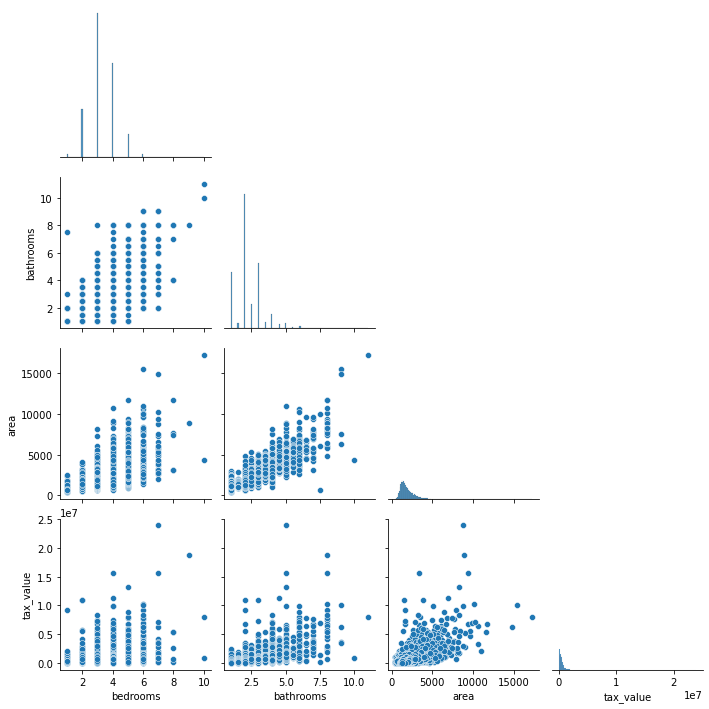

In [17]:
#Let's use sns.pairplot() to view a scatter plot visualizing the relationships between all of the numeric columns in our dataset all at once as well as individual distributions for each individual column.

# We can drop the redundant information in the upper right half of the chart if we like.

sns.pairplot(train[['bedrooms', 'bathrooms', 'area', 'tax_value']], corner=True)
plt.show()

In [18]:
# Start by exploring the variables individually

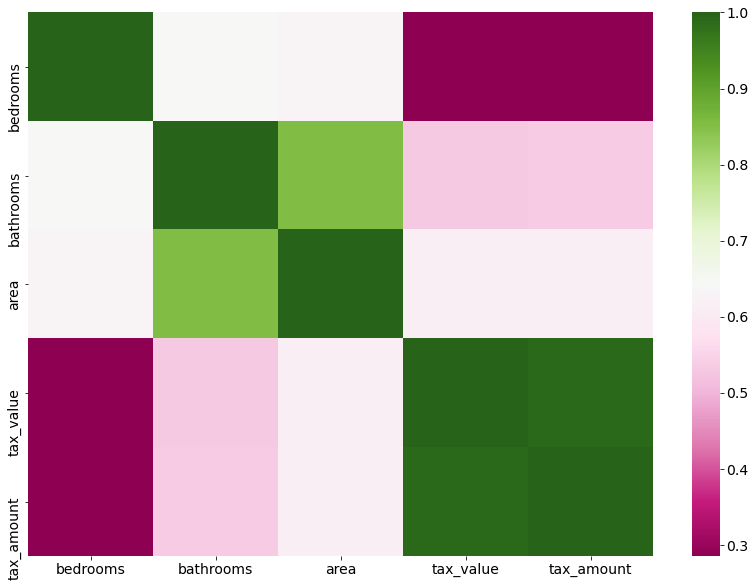

In [19]:
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))
sns.heatmap(train.corr(), cmap='PiYG')
#sns.heatmap(train2.corr(), cmap='mako', center=0, annot=True)
plt.show()

In [20]:
# Create the correlation matrix for all features.

exam_corr = train.drop(columns='tax_amount').corr()
exam_corr

,bedrooms,bathrooms,area,tax_value
bedrooms,1.000000,0.643445,0.632827,0.285247
bathrooms,0.643445,1.000000,0.854406,0.533410
area,0.632827,0.854406,1.000000,0.613511
tax_value,0.285247,0.533410,0.613511,1.000000


In [21]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.bathrooms, train.tax_value)
print(r, p_value)

0.5334098121884607 0.0


Based on my correlation coefficient and my p-value, I reject my Null hypothesis 2 that there is no correlation 
between baths and tax_value.

In [22]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.area, train.tax_value)
print(r, p_value)

0.6135108366287829 0.0


Based on my correlation coefficient and my p-value, I reject my Null hypothesis 1 that there is no correlation 
between sqft and tax_value.

In [26]:
# check for relationship between zipcode and tax_value
explore.run_chi2(train, 'zipcode', 'bedrooms')

(         chi2       p-value  degrees of freedom
 0  497.101807  4.242923e-94                  18,
 bedrooms  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0
 zipcode                                                             
 6037.0     152  1895  4676  2533   652   110    20     4     1     2
 6059.0      30   395  1842  1550   388    63     6     1     0     0
 6111.0       6   105   550   545   125    14     3     0     0     0,
             0            1            2            3           4           5  \
 0  120.529742  1535.471981  4531.405412  2967.083227  746.899732  119.888626   
 1   51.295634   653.473641  1928.497575  1262.745724  317.869224   51.022785   
 2   16.174623   206.054378   608.097013   398.171049  100.231044   16.088588   
 
            6         7         8         9  
 0  18.592354  3.205578  0.641116  1.282231  
 1   7.912624  1.364246  0.272849  0.545698  
 2   2.495022  0.430176  0.086035  0.172070  )

Based on the chi2 test we have a very low p value therefore we can conclude there is a high likelihood there is correlation between zipcode and bedrooms

### Takeaways
- bathrooms and bedrooms have a linear correlation that is not very strong
- bedrooms and tax_value do not have a strong linear correlation
- area and bathrooms have the strongest correlation I have seen so far
- tax_value and bathothrooms does not look like they have a strong linear correlation
- from the heatmap we can see area and bathrooms have the strongest correlation followed by bathrooms and bedrooms, next highest correlation is area and tax_value, and then bathrooms and and tax_value, and with the least correlation we see tax_value and bedrooms
- the correlation matrix indicates area has the highest correlation with tax_value at .61, followed by bathrooms and then bedrooms

# Modeling

In [ ]:
# I am going to scale in modeling
#before I scale I need to drop zipcode

In [ ]:
# def scale_dataset(train, validate, test):
#     #applying the robust scaler
#     scaler = sklearn.preprocessing.RobustScaler()
#     # Note that we only call .fit with the training data,
#     # but we use .transform to apply the scaling to all the data splits.
#     scaler.fit(X_train)

#     X_train_scaled = scaler.transform(X_train)
#     X_validate_scaled = scaler.transform(X_validate)
#     X_test_scaled = scaler.transform(X_test)
#     return X_train_scaled, X_validate_scaled, X_test_scaled

# plt.figure(figsize=(13, 6))
# plt.subplot(121)
# plt.hist(X_train, bins=25, ec='black')
# plt.title('Original')
# plt.subplot(122)
# plt.hist(X_train_scaled, bins=25, ec='black')
# plt.title('Scaled')

In [ ]:
#scale_dataset(train, validate, test)